# Problem 1

In [2]:
# match=1, gap_penalty=1, mismatch_penalty=1 (6 points)
def align(seq1, seq2, match=1, gap_penalty=1, mismatch_penalty=1):

    m, n = len(seq1), len(seq2)
    score_matrix = [[0] * (n + 1) for _ in range(m + 1)]
    traceback_matrix = [[None] * (n + 1) for _ in range(m + 1)]
    
    max_score = 0
    max_pos = None

    
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            matchscore = score_matrix[i - 1][j - 1] + (match if seq1[i - 1] == seq2[j - 1] else -mismatch_penalty)
            up = score_matrix[i - 1][j] - gap_penalty
            left = score_matrix[i][j - 1] - gap_penalty
            score_matrix[i][j] = max(0, matchscore, up, left)
            
            if score_matrix[i][j] == matchscore:
                traceback_matrix[i][j] = "diag"
            elif score_matrix[i][j] == up:
                traceback_matrix[i][j] = "up"
            elif score_matrix[i][j] == left:
                traceback_matrix[i][j] = "left"
            else:
                traceback_matrix[i][j] = None
            if score_matrix[i][j] > max_score:
                max_score = score_matrix[i][j]
                max_pos = (i, j)
    #returns an optimal local alignment and score
    aligned_seq1, aligned_seq2 = "", ""
    i, j = max_pos
    while traceback_matrix[i][j] is not None:
        if traceback_matrix[i][j] == "diag":
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            i -= 1
            j -= 1
        elif traceback_matrix[i][j] == "up":
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = "-" + aligned_seq2
            i -= 1
        elif traceback_matrix[i][j] == "left":
            aligned_seq1 = "-" + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            j -= 1

    return aligned_seq1, aligned_seq2, max_score

Example test

In [3]:
seq1, seq2, score = align('tgcatcgagaccctacgtgac', 'actagacctagcatcgac')
print (seq1, seq2, score)
seq1, seq2, score = align('tgcatcgagaccctacgtgac', 'actagacctagcatcgac', gap_penalty=2)
print (seq1, seq2, score)

atcgagacccta-cgt-gac a-ctaga-cctagcatcgac 8
gcatcga gcatcga 7


Self test  
Test it, and explain how your tests show that your function works. Be sure to test other values of match, gap_penalty, and mismatch_penalty 

In [16]:
seq1, seq2, score = align('GATTACA', 'GCATGCU', match=1, gap_penalty=1, mismatch_penalty=1)
print(seq1, seq2, score)
seq1, seq2, score = align('GATTACA', 'GCATGCU', match=5, gap_penalty=2, mismatch_penalty=2)
print(seq1, seq2, score)
seq1, seq2, score = align('GATTACA', 'GCATGCU', match=2, gap_penalty=0, mismatch_penalty=3)
print(seq1, seq2, score)

G-AT GCAT 2
G-ATTAC GCA-TGC 14
G-AT-TAC GCATG--C 8


The function can handle different gap penalty value and mismatch penalty

# Problem 2

In [76]:
import pandas as pd
data = pd.read_excel('Rice_Cammeo_Osmancik.xlsx')

In [77]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
#Normalize the seven quantitative columns to a mean of 0 and standard deviation 1.
scaler = StandardScaler()
#Reduce the data to two dimensions using PCA
pca = decomposition.PCA(n_components=2)
data_reduced = pca.fit_transform(scaler.fit_transform(data[['Area', 'Perimeter', 'Major_Axis_Length', 
                                      'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent']]))
pc0 = data_reduced[:, 0]
pc1 = data_reduced[:, 1]
data['PC1'] = pc0
data['PC2'] = pc1

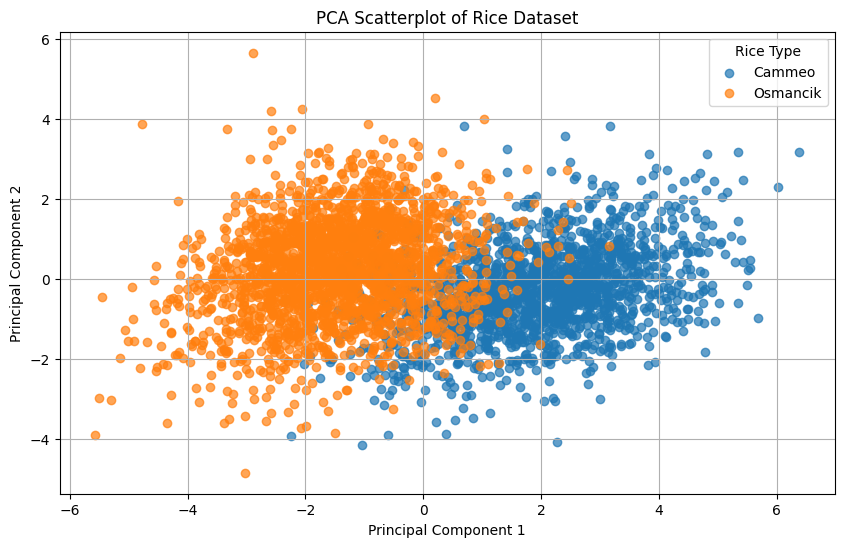

In [78]:
#Plot this on a scatterplot, color-coding by type of rice
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for rice_class in data['Class'].unique():
    subset = data[data['Class'] == rice_class]
    plt.scatter(subset['PC1'], subset['PC2'], label=rice_class, alpha=0.7)

plt.title('PCA Scatterplot of Rice Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Rice Type")
plt.grid(True)
plt.show()

Comment on what the graph suggests about the effeciveness of using k-nearest neighbors on this 2-dimensional reduction of the data to predict the type of rice.   

The graph suggests that the data can be classified into two types, so the k is better to set to 2. But there are still some data points are collaped to each other, which might decrease the accuracy close at 0

In [79]:
# store this data in a quad-tree
import numpy as np
class QuadTree:
    def __init__(self, xlo, ylo, xhi, yhi, max_points=4, depth=0):
        self.bounds = (xlo, ylo, xhi, yhi)
        self.max_points = max_points
        self.depth = depth
        self.points = []
        self.children = None

    def insert(self, point):
        if not self.within_bounds(point[0], point[1]):
            return False # not in bound of quadtree
        # if the points in one node is less then 4 points add point, else divide
        if len(self.points) < self.max_points:
            self.points.append(point)
            return True
        if self.children is None:
            self.subdivide()
        return any(child.insert(point) for child in self.children)

    def subdivide(self):
        xlo, ylo, xhi, yhi = self.bounds
        # divide the original space into 4 place by getting the mid point of length and width
        xmid = (xlo + xhi) / 2
        ymid = (ylo + yhi) / 2

        self.children = [
            QuadTree(xlo, ylo, xmid, ymid, self.max_points, self.depth + 1),
            QuadTree(xmid, ylo, xhi, ymid, self.max_points, self.depth + 1),
            QuadTree(xlo, ymid, xmid, yhi, self.max_points, self.depth + 1),
            QuadTree(xmid, ymid, xhi, yhi, self.max_points, self.depth + 1),
        ]

        for point in self.points:
            for child in self.children:
                if child.insert(point):
                    break

        self.points = []

    #get the nearest neighbour
    def query(self, x, y, k):
        neighbors = []
        self.query_recursive(x, y, k, neighbors)
        neighbors.sort(key=lambda p: np.sqrt((p[0] - x) ** 2 + (p[1] - y) ** 2))
        return neighbors[:k]

    def query_recursive(self, x, y, k, neighbors):
        if not self.within_bounds(x, y, margin=np.sqrt(0.5)):
    
            return
        if self.children is None:#is in the leaf
            neighbors.extend(self.points)
           
            return
        for child in self.children:# else search for its child
           
            child.query_recursive(x, y, k, neighbors)

    def within_bounds(self, x, y, margin=0):
        xlo, ylo, xhi, yhi = self.bounds
        return xlo - margin  <= x <= xhi  + margin and ylo - margin <= y <= yhi  + margin


#set the bound for the quadtree
points = list(zip(data['PC1'], data['PC2'], data['Class']))
xlo, ylo = data[['PC1', 'PC2']].min()
xhi, yhi = data[['PC1', 'PC2']].max()
#build the tree
quadtree = QuadTree(xlo, ylo, xhi, yhi)
for point in points:
    quadtree.insert(point)

# kNN
def quadknn(quadtree, x, y, k):
    neighbors = quadtree.query(x, y, k)
    classes = [neighbor[2] for neighbor in neighbors]
    return max(set(classes), key=classes.count)


In [80]:
from sklearn.model_selection import train_test_split
# split the train and test
train, test = train_test_split(data, test_size=0.3, random_state=42)
predictionfor1 = []
for _, row in test.iterrows():
    predictionfor1.append(quadknn(quadtree, row['PC1'], row['PC2'], 1))

predictionfor5 = []
for _, row in test.iterrows():
    predictionfor1.append(quadknn(quadtree, row['PC1'], row['PC2'], 5))
#give the confusion matrix for predicting the type of rice with k=1. (4 points) Repeat for k=5
actual = test['Class'].values
cm1 = pd.crosstab(pd.Series(actual, name='Actual'), pd.Series(predictionfor1, name='Predicted'))
cm5 = pd.crosstab(pd.Series(actual, name='Actual'), pd.Series(predictionfor1, name='Predicted'))


In [81]:
print(cm1,'\n',cm5)

Predicted  Cammeo  Osmancik
Actual                     
Cammeo        491        27
Osmancik       19       606 
 Predicted  Cammeo  Osmancik
Actual                     
Cammeo        491        27
Osmancik       19       606


The classifier has high overall accuracy with an accuracy 491+606/491+27+19+606, the four number stands for tp,fp,tn,fn for 491,27,19,606
The high true positive counts suggest the k-NN classifier is effective for this dataset.

# Problem 3

Calculation took 21.48177549999673 seconds


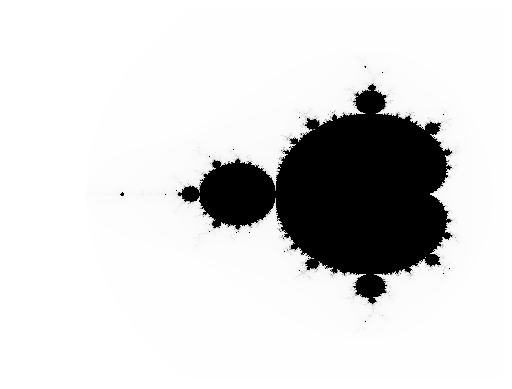

In [82]:
# original program
import matplotlib.pyplot as plt
import numpy
import time

xlo = -2.5
ylo = -1.5
yhi = 1.5
xhi = 0.75
nx = 2048
ny = 1536
dx = (xhi - xlo) / nx
dy = (yhi - ylo) / ny

iter_limit = 200
set_threshold = 2


def mandelbrot_test(x, y):
    z = 0
    c = x + y * 1j
    for i in range(iter_limit):
        z = z ** 2 + c
        if abs(z) > set_threshold:
            return i
    return i


def calculate_set():
    result = numpy.zeros([ny, nx])
    for i in range(ny):
        y = i * dy + ylo
        for j in range(nx):
            x = j * dx + xlo
            result[i, j] = mandelbrot_test(x, y)
    return result


if __name__ == "__main__":
    start_time = time.perf_counter()
    mandelbrot_set = calculate_set()
    stop_time = time.perf_counter()
    print(f"Calculation took {stop_time - start_time} seconds")
    plt.imshow(mandelbrot_set, interpolation="nearest", cmap="Greys")
    plt.gca().set_aspect("equal")
    plt.axis("off")
    plt.show()


In [ ]:
from mpi4py import MPI
if __name__ == "__main__":
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    rankrow = ny // size
    remainrow = ny % size

    if rank < remainrow:
        currentrow = rank * (rankrow + 1)
        i = rankrow + 1
    else:
        currentrow = rank * rankrow + remainrow
        i = rankrow

    start_time = time.perf_counter()
    local_result = calculate_set(currentrow, i)
    stop_time = time.perf_counter()
    print(f"Rank {rank}: Calculation took {stop_time - start_time} seconds")
    if rank == 0:
        final_result = np.zeros([ny, nx])
    else:
        final_result = None

    counts = np.array([rankrow + 1 if i < remainrow else rankrow for i in range(size)]) * nx
    displacements = np.cumsum(np.insert(counts[:-1], 0, 0))

    comm.Gatherv(sendbuf=local_result,
                 recvbuf=(final_result, counts, displacements, MPI.DOUBLE),
                 root=0)

    if rank == 0:
        plt.imshow(final_result, interpolation="nearest", cmap="Greys")
        plt.gca().set_aspect("equal")
        plt.axis("off")
        plt.show()

The result is shown here because in ipynb it can not run

The result generate by original and the mpi is 

original:

!['1'](ba1ea19b8b7a9516c0e7d689a5ec3c5.png)

the mpi one is：

!['2'](ec5fab057c26b6947e137d378718fb1.png)


The result of the mpi is:

!['s'](63b0449f4fc7ef4d1ab488d3eb26afe.png)

We can see that the parallel version runs much more faster than the original version, nearly 1/16 in 4 process, which runs meaningfully faster than the original.

The change is mainly that The Mandelbrot set computation was split into different rows, each process do differen job, then use MPI.COMM_WORLD to communicate through each rank.  
The limitation is that each rank might takes task that are not having same processing difficult, so that the total time is limited to the rank that has the highest difficult level. If each rank has similar process difficult, the time can be more faster.